## Playlist Song Recommendation

The goal of this model is to recommend songs to existing playlist. A playlist profile is first created using the songs currently present in the playlist. The profile is then used to perform a neighbourhood search using LSH algorithm and songs are recommended. 


To see more about the LSH alogrithm refer to this https://spark.apache.org/docs/2.2.3/ml-features.html#bucketed-random-projection-for-euclidean-distance

The datasets used are:


*   Spotify Tracks Dataset: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks
*   List item : https://zenodo.org/record/2594557#.YBNIWOhKhPb



In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.linalg.distributed import RowMatrix
# from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import MinMaxScaler
# from pyspark.mllib.linalg import *
import pandas as pd

In [ ]:
from pyspark.ml.feature import PCA, PCAModel

In [ ]:
# Create hash projections of the songs dataframe
datadf = ss.read.csv(DataPath,header=True,inferSchema=True,escape='\"',quote='\"')
data_df = datadf.withColumn('artists',translate('artists', '[','')).\
                withColumn('artists',translate('artists', ']','')).\
                withColumn('artists',translate('artists', "'",'')).\
                withColumn('artists',split('artists',',')).\
                withColumn("duration_ms",col("duration_ms")/60000).withColumnRenamed("duration_ms","duration")
dataDF = data_df.where((data_df['duration'] >= 0.5)&(data_df['duration'] <= 60))
dataDF2 = dataDF.select(col("*"),explode(dataDF.artists).alias('artistname_1'))
dataDF2 = dataDF2.groupBy('name', 'artistname_1').agg(first("mode").alias('mode'),mean('acousticness').alias('acousticness'),mean('danceability').alias('danceability'),\
                                    mean('duration').alias('duration'),mean('energy').alias('energy'), first('explicit').alias('explicit'),\
                                    mean('instrumentalness').alias('instrumentalness'),first('key').alias('key'),mean('liveness').alias('liveness'),\
                                    mean('loudness').alias('loudness'),mean('popularity').alias('popularity'),mean('speechiness').alias('speechiness'),\
                                    mean('tempo').alias('tempo'),mean('valence').alias('valence'),first('year').alias('year'))
dataDF2.show(2, truncate=False)

+----------------------------------------------------------------------------------------------+------------------------+----+------------+------------+-----------------+------+--------+------------------+---+--------+-------------------+----------+-----------+-----------------+-------+----+
|name                                                                                          |artistname_1            |mode|acousticness|danceability|duration         |energy|explicit|instrumentalness  |key|liveness|loudness           |popularity|speechiness|tempo            |valence|year|
+----------------------------------------------------------------------------------------------+------------------------+----+------------+------------+-----------------+------+--------+------------------+---+--------+-------------------+----------+-----------+-----------------+-------+----+
|Dervenakia                                                                                    | Klarino G. Anestopoulos|

In [ ]:
# Converting key into a one hot encoded vector
# Convert key feature into a one hot encoeded vector 
ohe = OneHotEncoder()
ohe.setInputCols(["key"])
ohe.setOutputCols(["key_vector"])
model = ohe.fit(dataDF2)
dataDF2_key_encoded = model.transform(dataDF2)
# dataDF2_key_encoded.show(2, truncate=False)

# Assemble all features into one to create a single vector
audio_feature_columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'explicit', 'key_vector']
assembler = VectorAssembler(
    inputCols=audio_feature_columns,
    outputCol="features")
dataDF2_feature = assembler.transform(dataDF2_key_encoded)
# dataDF2_feature.show(2, truncate=False)

# Scale all features using MinMax scaling method
mmScaler = MinMaxScaler(outputCol="scaled_features")
mmScaler.setInputCol("features")
model = mmScaler.fit(dataDF2_feature)
dataDF2_scaled = model.transform(dataDF2_feature)
# dataDF2_scaled.show(2, truncate=False)

# Convert sparse vectors into dense vectors
data_feature_rdd = dataDF2_scaled.select(['name', 'artistname_1', 'scaled_features']).rdd.map(list)
dataDF2_dense = data_feature_rdd.map(lambda kv: (kv[0], kv[1], DenseVector(kv[2].toArray()))).toDF()
dataDF2_dense = dataDF2_dense.withColumnRenamed('_1', 'name').withColumnRenamed('_2', 'artistname').withColumnRenamed('_3', 'scaled_features')
# dataDF2_dense.printSchema()
# artistdF_dense.show(2, truncate=False)

# Create Hash Projections
brp_song = BucketedRandomProjectionLSH(inputCol='scaled_features', outputCol='hashed_projections', seed=145, numHashTables=5, bucketLength=10)
brp_model_song = brp_song.fit(dataDF2_dense)
dataDF2_hashed = brp_model_song.transform(dataDF2_dense)
dataDF2_hashed.show(2, truncate=False)

+----------------------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|name                                    |artistname      |scaled_features                                                                                                                                                                                                                  |hashed_projections                     |
+----------------------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|En un Pueblito de Esp

In [ ]:
# Mapping the song features to 2-D using PCA to help visualize 
pca_song = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
model_pca_song = pca_song.fit(dataDF2_dense)
dataDF2_pca = model_pca_song.transform(dataDF2_dense)
dataDF2_pca.show(2, truncate=False)

+----------------------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------+
|name                                    |artistname      |scaled_features                                                                                                                                                                                                                  |pca_features                              |
+----------------------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------+
|En un Puebli

In [ ]:
# Joining the song and the playlist dataset
joinedDF_1 = spotifydf.join(dataDF2_dense,(dataDF2_dense.name==spotifydf.trackname)&(dataDF2_dense.artistname==spotifydf.artistname))
joinedDF_1.show(2, truncate=False)

+--------------------------------+----------+--------------------------------+----------------+--------------------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname                       |playlistname    |name                            |artistname|scaled_features                                                                                                                                                                                                         |
+--------------------------------+----------+--------------------------------+----------------+--------------------------------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Ecoding the key variable into one hot encoded vector in the joined df
joinedDF = spotifydf.join(dataDF2,(dataDF2.name==spotifydf.trackname)&(dataDF2.artistname_1==spotifydf.artistname))
ohe = OneHotEncoder()
ohe.setInputCols(["key"])
ohe.setOutputCols(["key_vector"])
model_1 = ohe.fit(joinedDF)
joinedDF_key_encoded = model_1.transform(joinedDF)

joinedDF_key_encoded = joinedDF_key_encoded.select(['user_id', 'name', 'artistname', 'playlistname'] + audio_feature_columns)

# Assembling it into one vector
audio_feature_columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'explicit', 'key_vector']
assembler_1 = VectorAssembler(
    inputCols=audio_feature_columns,
    outputCol="features")
joinedDF_feature = assembler_1.transform(joinedDF_key_encoded)
# dataDF2_feature.show(2, truncate=False)

# Scale all features using MinMax scaling method
mmScaler = MinMaxScaler(outputCol="scaled_features")
mmScaler.setInputCol("features")
model_2 = mmScaler.fit(joinedDF_feature)
joinedDF_scaled = model_2.transform(joinedDF_feature)

In [ ]:
joinedDF_scaled = joinedDF_scaled.select(['user_id', 'name', 'artistname', 'playlistname', 'scaled_features'])
joinedDF_scaled.show(2, truncate=False)

+--------------------------------+--------------------------------+----------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |name                            |artistname|playlistname    |scaled_features                                                                                                                                                                                                                           |
+--------------------------------+--------------------------------+----------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8104bd

In [ ]:
# Exploring the joined dataframe and looking at the scope of the problem
print("The total number of unique songs in the joined df is", joinedDF_scaled.select('name').distinct().count())
print("The total number of unique playlists in the joined df is", joinedDF_scaled.select('playlistname').distinct().count())

The total number of unique songs in the joined df is 58541
The total number of unique playlists in the joined df is 96039


In [ ]:
print("The total number of unique users in the joined df is", joinedDF_1.select('user_id').distinct().count())

The total number of unique users in the joined df is 15140


In [ ]:
playlist_song_count = joinedDF_scaled.groupby('playlistname').agg(countDistinct('name').alias('song_count'))
playlist_song_count.show(2, truncate=False)

+--------------------+----------+
|playlistname        |song_count|
+--------------------+----------+
|The Weeknd – Trilogy|31        |
|Rehearsal Dinner    |88        |
+--------------------+----------+
only showing top 2 rows



In [ ]:
# Finding playlists from the 3 groups

playlist_song_count.filter(col('song_count') <= 10).sort(col('song_count').desc()).show(10, truncate=False)
playlist_song_count.filter(col('song_count') <= 50).sort(col('song_count').desc()).show(20, truncate=False)
playlist_song_count.filter(col('song_count') <= 100).sort(col('song_count').desc()).show(25, truncate=False)


+-------------------------------------------------------------------+----------+
|playlistname                                                       |song_count|
+-------------------------------------------------------------------+----------+
|If I did a club night, it might sound a little something like this.|100       |
|Ashley's High School Years                                         |100       |
|C                                                                  |100       |
|ELVIS PRESLEY                                                      |100       |
|BANDA                                                              |100       |
|Summer Sun 2013                                                    |100       |
|SADHOUSE                                                           |100       |
|15 Years of Music                                                  |100       |
|Juan Alfonso                                                       |100       |
|Pump Up the Jam            

In [ ]:
joinedDF_scaled.createOrReplaceTempView('joined_playlist_table')
# joinedDF_scaled.groupby('playlistname').where(col('playlistname') == '25 and Alive').select('name').show(10, truncate=False)
ss.sql("SELECT DISTINCT(name), artistname FROM joined_playlist_table WHERE playlistname = 'If I did a club night, it might sound a little something like this.' LIMIT 15").show()

+--------------------+------------------+
|                name|        artistname|
+--------------------+------------------+
|                 PDA|          Interpol|
|         My Doorbell| The White Stripes|
|        Tutti Frutti|    Little Richard|
|          Doin' Time|           Sublime|
|  Walkin' On The Sun|       Smash Mouth|
|         Go It Alone|              Beck|
| Date With The Night|   Yeah Yeah Yeahs|
|      Heart Of Glass|           Blondie|
|   Pressure and Time|        Rival Sons|
|          Fineshrine|       Purity Ring|
|I Know Somethin (...|   Alice In Chains|
|       Holland, 1945|Neutral Milk Hotel|
|          Foxey Lady|      Jimi Hendrix|
|Frontier Psychiat...|    The Avalanches|
|             Holiday|   Vampire Weekend|
+--------------------+------------------+



Playlists selected:


1.   Optimist - 10 songs
2.   Aimlessly Drifting - 50 songs
3.   If I did a club night, it might sound a little something like this - 100 songs



In [ ]:
# Collecting the songs from each playlist
playlist_1_optimist = ss.sql("SELECT DISTINCT(name), artistname FROM joined_playlist_table WHERE playlistname = 'Optimist' ").collect()
playlist_2_drifting = ss.sql("SELECT DISTINCT(name), artistname FROM joined_playlist_table WHERE playlistname = 'Aimlessly Drifting' ").collect()
playlist_1_clubnight = ss.sql("SELECT DISTINCT(name), artistname FROM joined_playlist_table WHERE playlistname = 'If I did a club night, it might sound a little something like this.' ").collect()

In [ ]:
joinedDF_scaled.show(1, truncate=False)

+--------------------------------+------------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |name        |artistname|playlistname|scaled_features                                                                                                                                                                                                                           |
+--------------------------------+------------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8104bd55908290abee621a2851d48e37|'S Wonderful|Les Brown |Jazz        |(24,[0,1

In [ ]:
# Converting the song features in the joined df to dense vectors and creating playlist profiles

data_feature_rdd = joinedDF_scaled.select(['user_id', 'name', 'artistname', 'playlistname', 'scaled_features']).rdd.map(list)
joinedDF_dense_rdd = data_feature_rdd.map(lambda l: (l[0], l[1], l[2], l[3], DenseVector(l[4].toArray())))

In [ ]:
playlist_1_optimist_profile =  joinedDF_dense_rdd.map(lambda t: (t[3], (t[1], t[-1], 1)))\
                                                  .filter(lambda kv: kv[0] == 'Optimist')\
                                                  .map(lambda kv: (kv[1][0], (kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: ('a', (kv[1][0] / kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: kv[1][0] / kv[1][1])\
                                                  .collect()

playlist_2_drifting_profile =  joinedDF_dense_rdd.map(lambda t: (t[3], (t[1], t[-1], 1)))\
                                                  .filter(lambda kv: kv[0] == 'Aimlessly Drifting')\
                                                  .map(lambda kv: (kv[1][0], (kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: ('a', (kv[1][0] / kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: kv[1][0] / kv[1][1])\
                                                  .collect()

playlist_1_clubnight_profile =  joinedDF_dense_rdd.map(lambda t: (t[3], (t[1], t[-1], 1)))\
                                                  .filter(lambda kv: kv[0] == 'If I did a club night, it might sound a little something like this.')\
                                                  .map(lambda kv: (kv[1][0], (kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: ('a', (kv[1][0] / kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: kv[1][0] / kv[1][1])\
                                                  .collect()

In [ ]:
# Finding similar artists for the user using the nearest neighbour module of the randomized projection LSH
playlist_1_optimist_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, playlist_1_optimist_profile[0], 10, distCol='Distance_Measure').collect()
playlist_2_drifting_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, playlist_2_drifting_profile[0], 10, distCol='Distance_Measure').collect()
playlist_1_clubnight_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, playlist_1_clubnight_profile[0], 10, distCol='Distance_Measure').collect()

In [ ]:
# Top 10 songs Recommended to the 3 playlists by the LSH model
playlist_1_optimist_rsongs = []
playlist_1_optimist_rsongs_x = []
playlist_1_optimist_rsongs_y = []

playlist_2_drifting_rsongs = []
playlist_2_drifting_rsongs_x = []
playlist_2_drifting_rsongs_y = []

playlist_1_clubnight_rsongs = []
playlist_1_clubnight_rsongs_x = []
playlist_1_clubnight_rsongs_y = []

for i in playlist_1_optimist_neighbours:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_1_optimist_rsongs.append((i.name, coordinate))
  playlist_1_optimist_rsongs_x.append(coordinate[0])
  playlist_1_optimist_rsongs_y.append(coordinate[1])

for i in playlist_2_drifting_neighbours:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_2_drifting_rsongs.append((i.name, coordinate))
  playlist_2_drifting_rsongs_x.append(coordinate[0])
  playlist_2_drifting_rsongs_y.append(coordinate[1])

for i in playlist_1_clubnight_neighbours:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_1_clubnight_rsongs.append((i.name, coordinate))
  playlist_1_clubnight_rsongs_x.append(coordinate[0])
  playlist_1_clubnight_rsongs_y.append(coordinate[1])

## Visualizing Results

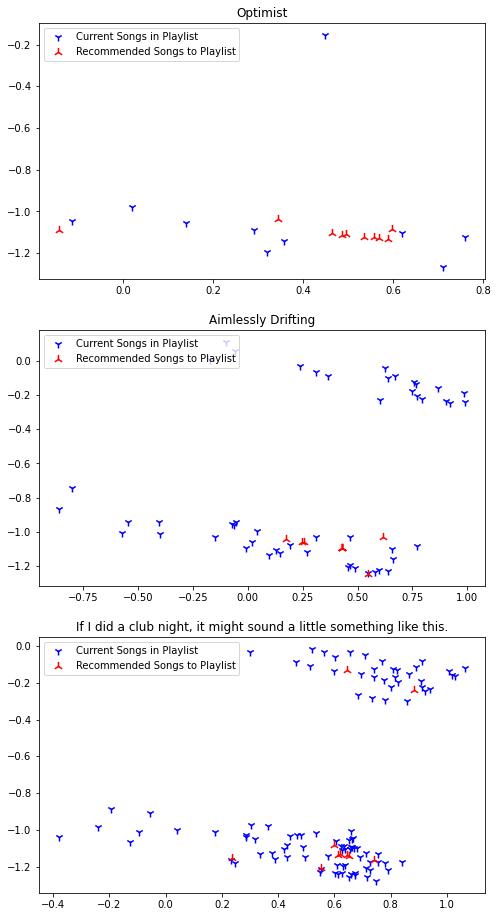

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plotting songs present in playlists compared to songs suggested 
fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


ax1.scatter(playlist_1_optimist_songs_x, playlist_1_optimist_songs_y, s=65, c='b', marker="1", label='Current Songs in Playlist')
ax1.scatter(playlist_1_optimist_rsongs_x, playlist_1_optimist_rsongs_y, s=85, c='r', marker="2", label='Recommended Songs to Playlist')

ax2.scatter(playlist_2_drifting_songs_x, playlist_2_drifting_songs_y, s=65, c='b', marker="1", label='Current Songs in Playlist')
ax2.scatter(playlist_2_drifting_rsongs_x, playlist_2_drifting_rsongs_y, s=85, c='r', marker="2", label='Recommended Songs to Playlist')

ax3.scatter(playlist_1_clubnight_songs_x, playlist_1_clubnight_songs_y, s=65, c='b', marker="1", label='Current Songs in Playlist')
ax3.scatter(playlist_1_clubnight_rsongs_x, playlist_1_clubnight_rsongs_y, s=85, c='r', marker="2", label='Recommended Songs to Playlist')

ax1.set_title('Optimist')
ax2.set_title('Aimlessly Drifting')
ax3.set_title('If I did a club night, it might sound a little something like this.')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

plt.show()
plt.savefig('Playlist-Song Recommendations')